#### Installing & importing libraries

In [ ]:

!pip install fredapi --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Setting up FRED API

In [ ]:
fred = Fred(api_key='6eb8ef6be93103a60a82a65f50cc036c')  # Replace with your real key
start_date = '2000-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

###Downloading raw macro and yield data

In [ ]:
y10 = fred.get_series('GS10', observation_start=start_date)
y2 = fred.get_series('GS2', observation_start=start_date)
y3m = fred.get_series('GS3M', observation_start=start_date)
unemp = fred.get_series('UNRATE', observation_start=start_date)
infl = fred.get_series('CPIAUCSL', observation_start=start_date)
recession = fred.get_series('USREC', observation_start=start_date)

###Combine and create raw features

In [ ]:
df = pd.concat([y10, y2, y3m, unemp, infl, recession], axis=1)
df.columns = ['10Y', '2Y', '3M', 'Unemployment', 'Inflation', 'Recession']
df = df.dropna()

####Derived features & labels

In [ ]:
df['10Y-2Y'] = df['10Y'] - df['2Y']
df['10Y-3M'] = df['10Y'] - df['3M']
df['Inversion'] = (df['10Y-2Y'] < 0).astype(int)

###New addition Feature engineering - add rolling and momentum features

In [ ]:
df['Inflation_Momentum'] = df['Inflation'].pct_change(periods=3)
df['Unemployment_3mo_Avg'] = df['Unemployment'].rolling(window=3).mean()
df['10Y-2Y_Momentum'] = df['10Y-2Y'].diff(3)
df = df.dropna()

####Create lagged features

In [ ]:
base_features = ['10Y-2Y', '10Y-3M', 'Unemployment', 'Inflation', 'Recession',
                 'Inflation_Momentum', 'Unemployment_3mo_Avg', '10Y-2Y_Momentum']
for col in base_features:
    df[f'{col}_lag1'] = df[col].shift(1)

####Create target (t+1 inversion)

In [ ]:
df['Inversion_t+1'] = df['Inversion'].shift(-1)
df = df.dropna()

###Define features and scale them

In [ ]:
features = [f'{col}_lag1' for col in base_features]
target = 'Inversion_t+1'

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

####Windowing for LSTM

In [ ]:
sequence_length = 6
X, y = [], []
for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[features].iloc[i-sequence_length:i].values)
    y.append(df_scaled[target].iloc[i])

X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

X shape: (293, 6, 8)
y shape: (293,)
Train shape: (234, 6, 8)
Test shape: (59, 6, 8)


####Handling class imbalance

In [ ]:
class_weights = {
    0: (1 / np.sum(y_train == 0)),
    1: (1 / np.sum(y_train == 1))
}

####Define and compile LSTM model

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Balancing and Oversampling

In [ ]:
from sklearn.utils import resample

# Flatten X_train for resampling
X_flat = X_train.reshape((X_train.shape[0], -1))
df_train = pd.DataFrame(X_flat)
df_train['target'] = y_train

# Separate classes
majority = df_train[df_train['target'] == 0]
minority = df_train[df_train['target'] == 1]

# Upsample minority to match majority count
minority_upsampled = resample(minority,
                               replace=True,
                               n_samples=len(majority),
                               random_state=42)

# Combine
df_balanced = pd.concat([majority, minority_upsampled])

# Shuffle and reshape
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
y_train_bal = df_balanced['target'].values
X_train_bal = df_balanced.drop(columns='target').values.reshape(-1, X_train.shape[1], X_train.shape[2])

# Sanity check
print("Balanced training shape:", X_train_bal.shape)
print("Class counts:", dict(zip(*np.unique(y_train_bal, return_counts=True))))


Balanced training shape: (440, 6, 8)
Class counts: {np.float64(0.0): np.int64(220), np.float64(1.0): np.int64(220)}


####Train the model with early stopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(LSTM(32, input_shape=(X_train_bal.shape[1], X_train_bal.shape[2]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(
    X_train_bal, y_train_bal,
    epochs=100,
    batch_size=8,
    validation_data=(X_test, y_test),  # still using original test set
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5496 - loss: 0.6608 - val_accuracy: 0.7797 - val_loss: 0.5334
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8444 - loss: 0.3841 - val_accuracy: 0.6271 - val_loss: 0.5926
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9254 - loss: 0.2771 - val_accuracy: 0.5254 - val_loss: 0.7743
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9605 - loss: 0.1847 - val_accuracy: 0.5085 - val_loss: 0.9905
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9530 - loss: 0.1629 - val_accuracy: 0.4746 - val_loss: 1.1687
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9700 - loss: 0.1136 - val_accuracy: 0.4576 - val_loss: 1.2564
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9721 - loss: 0.1043 - val_accuracy: 0.4576 - val_loss: 1.2885
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9798 - loss: 0.0743 - val_accuracy: 0.4576 - val_loss: 1.

###Evaluate performance

In [ ]:
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nTest AUC:", roc_auc_score(y_test, y_pred_probs))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.61      0.75        33
         1.0       0.67      1.00      0.80        26

    accuracy                           0.78        59
   macro avg       0.83      0.80      0.78        59
weighted avg       0.85      0.78      0.77        59


Confusion Matrix:
[[20 13]
 [ 0 26]]

Test AUC: 0.965034965034965


###Plot ROC curve

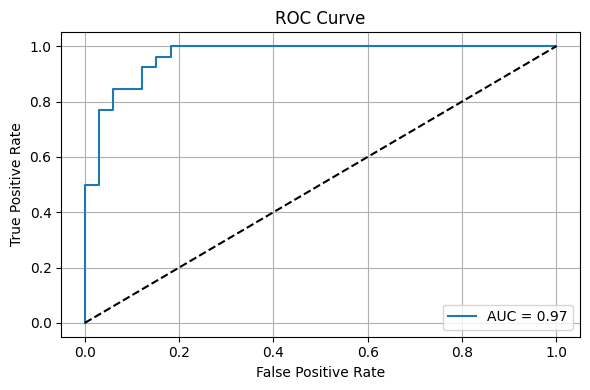

In [ ]:

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_probs):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Save test predictions for use in later modules

In [ ]:
# Uncomment and run after making predictions using your trained LSTM
import os
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)
output_df = pd.DataFrame({
     'Date': df_scaled.index[-len(y_test):],
     'Actual_Inversion': y_test,
     'Predicted_Probability': y_pred_probs,
     'Predicted_Inversion': y_pred
 })
output_path = "/content/drive/MyDrive/Fintech-Project/data/module1c_output.csv"
output_df.to_csv(output_path)
print(f"✅ Saved Module 1c outputs to {output_path}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
✅ Saved Module 1c outputs to /content/drive/MyDrive/Fintech-Project/data/module1c_output.csv


####Make one-month ahead prediction from latest data

In [82]:

latest_window = df_scaled[features].iloc[-sequence_length:].values
latest_window_scaled = np.expand_dims(latest_window, axis=0)
next_month_prob = model.predict(latest_window_scaled)[0][0]
next_month_inversion = int(next_month_prob > 0.5)

print(f"\n🧠 Predicted Probability of Inversion (Next Month): {next_month_prob:.4f}")
print(f"🔮 Predicted Inversion (1 = Yes, 0 = No): {next_month_inversion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

🧠 Predicted Probability of Inversion (Next Month): 0.4797
🔮 Predicted Inversion (1 = Yes, 0 = No): 0


In [84]:

future_date = df_scaled.index[-1] + pd.DateOffset(months=1)

# ✅ Create DataFrame for the future prediction
future_output = pd.DataFrame({
    'Date': [future_date],
    'Actual_Inversion': [None],
    'Predicted_Probability': [next_month_prob],
    'Predicted_Inversion': [next_month_inversion]
})
future_output.set_index('Date', inplace=True)

# ✅ Append to existing output CSV
output_path = "/content/drive/MyDrive/Fintech-Project/data/module1c_output.csv"
existing = pd.read_csv(output_path, index_col=0, parse_dates=True)
final_df = pd.concat([existing, future_output])
final_df.to_csv(output_path)
print(f"✅ Appended future prediction to {output_path}")

✅ Appended future prediction to /content/drive/MyDrive/Fintech-Project/data/module1c_output.csv


<ipython-input-84-ea62f47ba662>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  existing = pd.read_csv(output_path, index_col=0, parse_dates=True)
<ipython-input-84-ea62f47ba662>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([existing, future_output])
